导入所需要的模块

In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

加载和准备数据

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


数据简介¶

此数据集包含的是从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列。你可以在上方看到前几行数据。

下图展示的是数据集中前 10 天左右的骑车人数（某些天不一定是 24 个条目，所以不是精确的 10 天）。你可以在这里看到每小时租金。这些数据很复杂！周末的骑行人数少些，工作日上下班期间是骑行高峰期。我们还可以从上方的数据中看到温度、湿度和风速信息，所有这些信息都会影响骑行人数。

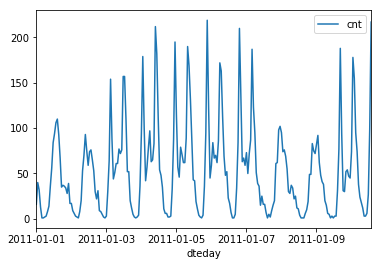

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

对一些分类变量（如季节，天气，月份），创建二进制虚拟变量

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### 调整目标变量

为了更轻松地训练网络，我们将对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### 将数据拆分为训练、测试和验证数据集

我们将大约最后 21 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的骑行人数进行对比。

In [9]:
test_data = data[-21*24:]

data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 开始构建网络

模型采用神经网络，只有一个隐藏层，激活函数为S型函数，实现前向传递和反向传递
<img src="assets/neural_network.png" width=300px>

In [10]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        self.activation_function = lambda x : 1 / (1 + np.exp(-x)) 
        
                    
    
    def train(self, features, targets):

        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):

            hidden_inputs = np.dot(X,self.weights_input_to_hidden) 
            hidden_outputs = self.activation_function(hidden_inputs) 

            final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) 
            final_outputs = final_inputs 


            error = y - final_outputs 
            
            hidden_error = np.dot(self.weights_hidden_to_output,error)
            
            output_error_term = error
            hidden_error_term = np.multiply(hidden_error.T,hidden_outputs * (1 - hidden_outputs))

            delta_weights_i_h += X[:,None] * hidden_error_term

            delta_weights_h_o += hidden_outputs[:,None] * output_error_term

        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records 
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records 
 
    def run(self, features):
        
        hidden_inputs = np.dot(features,self.weights_input_to_hidden) 
        hidden_outputs = self.activation_function(hidden_inputs) 
        
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output)
        final_outputs = final_inputs 
        
        return final_outputs

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 训练网络

选择合适的迭代次数：迭代次数越多，模型与数据越拟合，但如果迭代次数太多，模型无法很好地泛化到其他数据。
选择合适的学习速率：速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。
选择隐藏节点数量：隐藏节点越多，模型的预测结果就越准确。如果影藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。


In [14]:
import sys

iterations = 8000
learning_rate = 0.25
hidden_nodes = 10
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):

    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    

    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.069 ... Validation loss: 0.132

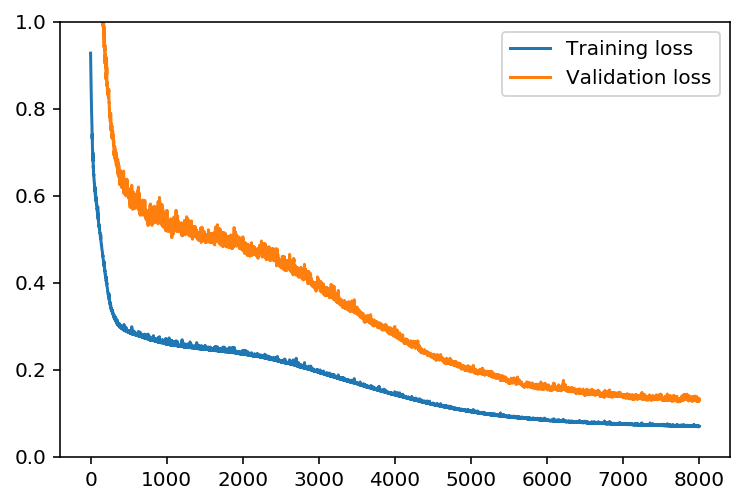

In [15]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim(ymax = 1,ymin = 0)

## 检查预测结果

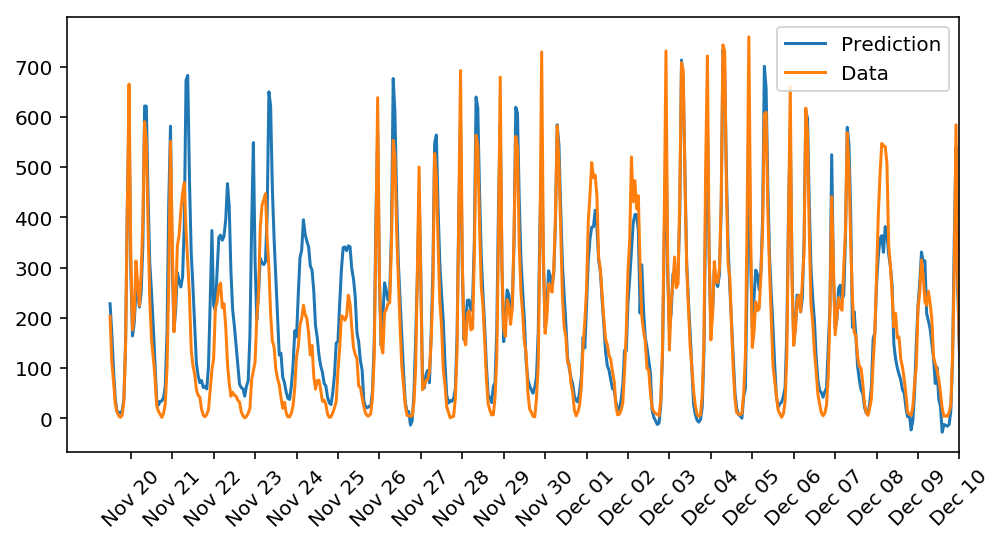

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)